In [99]:
# pandas
import pandas as pd
from pandas import Series,DataFrame
from datetime import datetime as datetime
import re as re
# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')
pd.options.mode.chained_assignment = None  # default='warn'

In [100]:
df = pd.read_csv('Bookings per stashpoint prediciton.csv')  
df['activated'] = pd.to_datetime(df['activated'] , errors='coerce')

# Filter to only include stashpoints in the UK (country == 'GBR')
df = df[df['country'] == 'GBR'].copy()

df.head()

,stashpoint_id,bookings_90d,business_name,country,type,capacity,activated,sps_within_500m,units_supply_within_500m,review_count_90d,avg_review_rating_90d,searches_last_90
3,21ee810bc764,2,Foodwise Express,GBR,convenience_store,50,2024-11-06,24,1355,0,NaN,7958
5,6f169b288d15,3,Foodwise Local,GBR,convenience_store,10,2025-05-29,24,1395,0,NaN,7953
9,08b673bc5584,113,Europa House Hotel,GBR,hotel,200,2023-07-26,23,1156,4,4.75,4388
11,5c806eaca40c,11,Sonic Paddington Souvenirs,GBR,luggage_storage_shop,100,2025-03-05,23,1255,0,NaN,7925
13,b612231f182c,3,Mail Boxes Etc,GBR,postal_shop,50,2020-05-25,23,1305,0,NaN,7946


In [101]:
print(df.columns.tolist()) 

['stashpoint_id', 'bookings_90d', 'business_name', 'country', 'type', 'capacity', 'activated', 'sps_within_500m', 'units_supply_within_500m', 'review_count_90d', 'avg_review_rating_90d', 'searches_last_90']


In [102]:
# list of unique locations type 
#print(df['type'].value_counts())
# Group some of them 

type_mapping = {
    # Hospitality
    'hotel': 'hospitality',
    'hostel': 'hospitality',
    'premier_inn_hotel': 'hospitality',
    'staycity_hotel': 'hospitality',
    'wilde_aparthotel': 'hospitality',
    'yha_hostel': 'hospitality',
    'marriott_courtyard_hotel': 'hospitality',
    'concordia_boutique_hotel': 'hospitality',
    'sofitel_hotel': 'hospitality',
    'ihg_crowne_plaza_hotel': 'hospitality',

    # Retail
    'shop': 'retail',
    'convenience_store': 'retail',
    'tech_shop': 'retail',
    'postal_shop': 'retail',
    'luggage_storage_shop': 'retail',
    'rental_shop': 'retail',
    'souvenir_shop': 'retail',
    'newsagent': 'retail',
    'smoke_shop': 'retail',

    # Food & Beverage
    'food_and_beverage_business': 'food',
    'restaurant': 'food',
    'cafe': 'food',

    # Services
    'office': 'services',
    'health_beauty_business': 'services',
    'laundry_business': 'services',

    # Utility
    'car_park': 'utility',

    # Locker
    'locker': 'locker'
}

# Apply grouping
df['type_grouped'] = df['type'].map(type_mapping).fillna('other')
print(df['type_grouped'].value_counts())

type_grouped
locker         952
retail         380
hospitality    378
services       120
food            99
utility          1
Name: count, dtype: int64


In [103]:
# One-hot encode 'type_grouped' and drop the original column
df = pd.get_dummies(df, columns=['type_grouped'], prefix='type', drop_first=True)

In [104]:
# Drop non needed 
df.drop(['country', 'type'], axis=1, inplace=True)

In [105]:
## Additional variables 

today = pd.Timestamp.today()
df['age_in_days'] = (today - df['activated']).dt.days

# Competition density (stashpoints per unit) (removed as v weak correlation) 
df['competition_density'] = df['sps_within_500m'] / (df['units_supply_within_500m'] + 1)

# Search to supply ratio
df['search_to_supply_ratio'] = df['searches_last_90'] / (df['units_supply_within_500m'] + 1)

In [106]:
# Dealing with too many missings

missing_pct = df.isnull().mean().sort_values(ascending=False)
#print(missing_pct)

zero_pct = (df == 0).mean(numeric_only=True).sort_values(ascending=False)
#print(zero_pct)


In [107]:
threshold_missing = 0.3 # Remove if > 30% missing 
threshold_zero = 0.8 # remove if > 80% are 0

cols_to_drop = missing_pct[missing_pct > threshold_missing].index.tolist()
cols_to_drop += zero_pct[zero_pct > threshold_zero].index.tolist()
cols_to_drop = list(set(cols_to_drop))  # remove duplicates

print("Columns to consider dropping:", cols_to_drop)

Columns to consider dropping: ['avg_review_rating_90d', 'type_services', 'type_hospitality', 'type_retail', 'review_count_90d', 'type_utility']


In [108]:
df.drop(['review_count_90d', 'avg_review_rating_90d'], axis=1, inplace=True)

In [109]:
df.head() 

,stashpoint_id,bookings_90d,business_name,capacity,activated,sps_within_500m,units_supply_within_500m,searches_last_90,type_hospitality,type_locker,type_retail,type_services,type_utility,age_in_days,competition_density,search_to_supply_ratio
3,21ee810bc764,2,Foodwise Express,50,2024-11-06,24,1355,7958,False,False,True,False,False,243,0.017699,5.868732
5,6f169b288d15,3,Foodwise Local,10,2025-05-29,24,1395,7953,False,False,True,False,False,39,0.017192,5.696991
9,08b673bc5584,113,Europa House Hotel,200,2023-07-26,23,1156,4388,True,False,False,False,False,712,0.019879,3.792567
11,5c806eaca40c,11,Sonic Paddington Souvenirs,100,2025-03-05,23,1255,7925,False,False,True,False,False,124,0.018312,6.309713
13,b612231f182c,3,Mail Boxes Etc,50,2020-05-25,23,1305,7946,False,False,True,False,False,1869,0.017611,6.084227


In [110]:
#Run correlation analysis 

In [111]:
import matplotlib.pyplot as plt

# Compute correlations with target
correlations = df.corr(numeric_only=True)['bookings_90d'].drop('bookings_90d').sort_values()
correlations
# Plot
#plt.figure(figsize=(8, 6))
#correlations.plot(kind='barh')
#plt.title('Feature Correlation with Bookings (Pearson)')
#plt.xlabel('Correlation Coefficient')
#plt.grid(True)
#plt.tight_layout()
#plt.show()

type_locker                -0.201632
type_services              -0.044562
competition_density        -0.035142
type_utility                0.017603
type_retail                 0.038647
search_to_supply_ratio      0.187307
age_in_days                 0.213924
capacity                    0.215565
type_hospitality            0.261021
sps_within_500m             0.298497
units_supply_within_500m    0.334850
searches_last_90            0.488269
Name: bookings_90d, dtype: float64

#### Summary of Correlation Strengths

In [112]:
# searches_last_90	0.49	Strongest linear relationship — keep.
# units_supply_within_500m	0.33	Moderate — keep.
# sps_within_500m	0.30	Moderate — keep.
# type_hospitality	0.26	Meaningful categorical feature — keep.
# capacity	0.22	Reasonable — keep.
# age_in_days	0.21	Time since activation — useful.
# search_to_supply_ratio	0.19	Demand-supply proxy — useful.
# type_retail	0.04	Weak, may keep depending on importance in model.
# type_utility	0.02	Negligible correlation — consider dropping.
# competition_density	-0.04	Very weak negative — consider dropping.
# type_services	-0.04	Also weak — consider dropping.
# type_locker	-0.20	Slightly negative, may indicate niche behavior — optional.

#Correlation is a univariate linear relationship

#correlation = -0.035  # Very weak
#This says: across the dataset, competition_density alone has almost no direct linear relationship with bookings_90d.

#However, this doesn't account for its interaction or collinearity with other variables (like sps_within_500m or units_supply_within_500m).


In [113]:
# Run the Ridge regression coefficients to confirm whether weakly correlated variables actually have low impact in the model. 

In [114]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Select features and target 
X = df.drop(columns=['stashpoint_id', 'bookings_90d', 'activated'], errors='ignore')
X = X.select_dtypes(include=['number'])  # Keep only numeric columns
y = df['bookings_90d']
# Standardize numeric features
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Split into train/test (optional for now)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit Ridge regression
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# Get coefficients
coefficients_ridge = pd.Series(model.coef_, index=X.columns).sort_values()
coefficients_ridge
# Plot
#plt.figure(figsize=(8, 6))
#coefficients.plot(kind='barh')
#plt.title('Feature Importance via Ridge Regression')
#plt.xlabel('Coefficient Value')
#plt.grid(True)
#plt.tight_layout()
#plt.show()

units_supply_within_500m    -1.360777
competition_density         -0.687881
sps_within_500m              0.713616
age_in_days                  8.254867
search_to_supply_ratio       8.766311
capacity                    10.538868
searches_last_90            56.193497
dtype: float64

In [115]:
###Feature	Coefficient	Interpretation
# Positive: 
#searches_last_90	56.19	🔥 Strongest driver — more searches nearby = more bookings.
#capacity	10.54	Higher capacity → more bookings.
#search_to_supply_ratio	8.77	Demand relative to supply matters.
#age_in_days	8.25	Older stashpoints tend to get more bookings (established trust).
#sps_within_500m	0.71	Slight positive influence — competition may attract attention.

# Negative: 
#competition_density	-0.69	Too much competition per unit might hurt.
#units_supply_within_500m	-1.36	Nearby excess supply may dilute demand.

competition_density Ridge coefficient = -0.688  # Moderate negative
This means: when holding all other variables constant, a 1 standard deviation increase in competition_density is associated with a decrease in bookings.

The Ridge model penalizes correlated predictors (like sps_within_500m), so its effectively saying:
“Given that sps_within_500m is already included and positively important, the remaining unique effect of competition_density is negative.”

Why sps_within_500m is positive but competition_density is negative? 
This is the core insight:
sps_within_500m: raw count of competitors nearby — positive effect → suggests a higher-density area that attracts users (like a busy train station).
competition_density = sps / (units + 1): normalizes competition per unit of supply → if a place has many stashpoints but little supply, its hyper-competitive — this makes sense to negatively affect your stashpoint.

More competition is OK when there’s ample demand and supply, but bad when it’s too tight?


In [116]:
# Keep competition_density for now, especially in regularized models like Ridge or Lasso.
# Monitor Variance Inflation Factor (VIF) if you plan to fit a regular linear regression (to diagnose multicollinearity).
# Consider trying models like Random Forest, which are less sensitive to collinearity and can show importance more robustly.

In [117]:
# Let's try a Random Forest 
# handles non-linearities.
#robust to multicollinearity. 

In [118]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare features and target
X = df.drop(columns=['stashpoint_id', 'bookings_90d', 'activated'], errors='ignore')
X = X.select_dtypes(include=['number'])  # keep numeric only
y = df['bookings_90d']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Random Forest R²: {r2:.3f}')
print(f'Random Forest RMSE: {rmse:.2f}')

Random Forest R²: 0.436
Random Forest RMSE: 80.51


R² = 0.436 →  model explains ~44% of the variance in bookings.

RMSE = 80.51 → On average, your predictions are off by ~80 bookings over 90 days.



In [119]:
# Feature importance (Feature rankings: Based on actual contribution to model accuracy, not just linear effect) 
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()
importances

# Plot
#plt.figure(figsize=(8, 6))
#importances.plot(kind='barh')
#plt.title('Feature Importance (Random Forest)')
#plt.xlabel('Importance Score')
#plt.tight_layout()
#plt.grid(True)
#plt.show()

competition_density         0.062658
units_supply_within_500m    0.067322
capacity                    0.085603
sps_within_500m             0.098018
age_in_days                 0.099447
search_to_supply_ratio      0.136782
searches_last_90            0.450170
dtype: float64

### Feature Importance (Random Forest)

In [120]:
# searches_last_90	0.45	🔥 Most influential — demand signal is key.
# search_to_supply_ratio	0.14	High demand per supply = more bookings.
# age_in_days	0.10	Older hosts get more bookings — likely more visibility/trust.
# sps_within_500m	0.10	More nearby stashpoints = more visibility or clustering benefits.
# capacity	0.09	More space = more opportunity to book.
# units_supply_within_500m	0.07	Local supply matters, but less so than demand.
# competition_density	0.06	✅ Still contributes — not a top feature, but not noise.

In [121]:
# The case of competition density: 
# competition_density should be kept — it has meaningful but secondary predictive value.
# Its importance > 0.05, which is often used as a soft threshold in Random Forest to separate signal from noise.
# Its negative sign in Ridge and modest importance in RF suggest it's a refining feature, not a driver — helpful for adjusting predictions downward when competition is fierce.


In [122]:
# Step 1: Export Top 10 Drivers Ranked by Ridge + Random Forest

In [123]:
# Ridge coefficients (absolute value for ranking)
ridge_coefs = abs(pd.Series(model.coef_, index=X.columns))

# Random Forest feature importances
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Rank features
ridge_rank = ridge_coefs.rank(ascending=False)
rf_rank = rf_importances.rank(ascending=False)

# Average rank
avg_rank = (ridge_rank + rf_rank) / 2

# Combine everything into one DataFrame
combined = pd.DataFrame({
    'ridge_coef': ridge_coefs,
    'rf_importance': rf_importances,
    'ridge_rank': ridge_rank,
    'rf_rank': rf_rank,
    'avg_rank': avg_rank
}).sort_values('avg_rank')

# Export and print top 10
top_10 = combined.head(10)
top_10.to_csv("top_10_features_ridge_rf.csv")
print(top_10)

                          ridge_coef  rf_importance  ridge_rank  rf_rank  \
searches_last_90           56.193497       0.450170         1.0      1.0   
search_to_supply_ratio      8.766311       0.136782         3.0      2.0   
capacity                   10.538868       0.085603         2.0      5.0   
age_in_days                 8.254867       0.099447         4.0      3.0   
sps_within_500m             0.713616       0.098018         6.0      4.0   
units_supply_within_500m    1.360777       0.067322         5.0      6.0   
competition_density         0.687881       0.062658         7.0      7.0   

                          avg_rank  
searches_last_90               1.0  
search_to_supply_ratio         2.5  
capacity                       3.5  
age_in_days                    3.5  
sps_within_500m                5.0  
units_supply_within_500m       5.5  
competition_density            7.0  


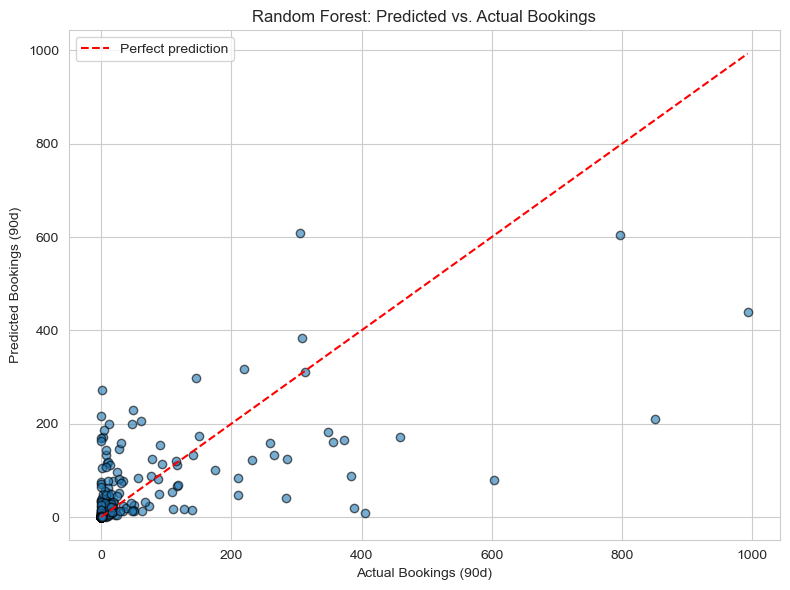

In [124]:
import matplotlib.pyplot as plt

# Ensure you have y_test and y_pred from earlier RF model
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')

# Reference line: perfect prediction (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Bookings (90d)")
plt.ylabel("Predicted Bookings (90d)")
plt.title("Random Forest: Predicted vs. Actual Bookings")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## SHAP

In [125]:
import shap


# Create SHAP explainer using trained Random Forest
explainer = shap.Explainer(rf, X_train)

# Compute SHAP values for test data (or the whole X if small)
shap_values = explainer(X_test, check_additivity=False)

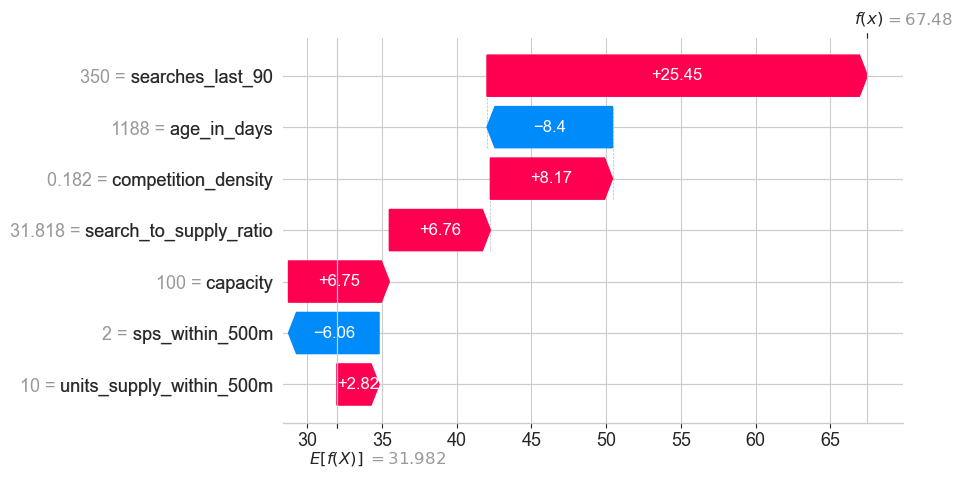

In [126]:
# Pick a test row index (e.g., the first one)
i = 12  # change to any index you want

# Waterfall plot: how each feature contributes to prediction
shap.plots.waterfall(shap_values[i])

In [127]:
# Check actual prediction for stashpoint index 12 (same as SHAP)
i = 12
print("Raw model prediction:", rf.predict([X_test.iloc[i]])[0])
print("Actual bookings:", y_test.iloc[i])

Raw model prediction: 67.48
Actual bookings: 117


C:\Users\brethm01\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [128]:
# SHAP sum + base_value = model output
shap_sum = shap_values[i].values.sum()
base = shap_values[i].base_values
pred = shap_sum + base

print(f"SHAP-predicted: {pred}")
print(f"RF-predicted: {rf.predict([X_test.iloc[i]])[0]}")
print(f"Actual: {y_test.iloc[i]}")

SHAP-predicted: 67.48000010362314
RF-predicted: 67.48
Actual: 117


C:\Users\brethm01\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


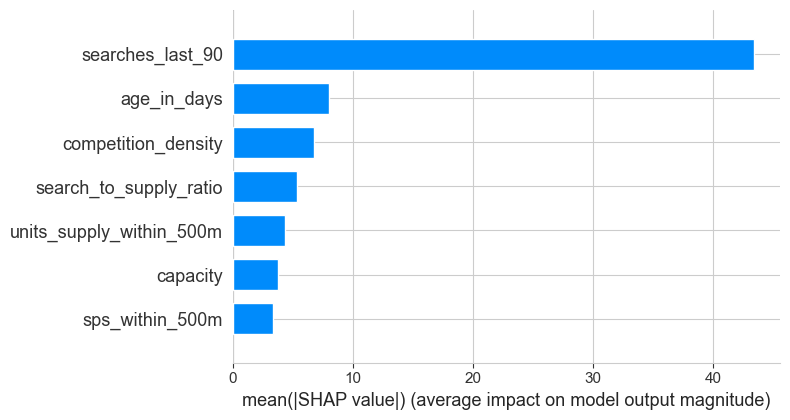

In [129]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [130]:
import pandas as pd
import shap

# 1. Re-create SHAP explainer on the test data
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test, check_additivity=False)

# 2. Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns, index=X_test.index)

# 3. Add predicted values and actual bookings
shap_df['prediction'] = rf.predict(X_test)
shap_df['actual'] = y_test.values

# 4. Add SHAP base value (mean prediction of model)
shap_df['base_value'] = shap_values.base_values

# 5. Export
shap_df.to_csv("shap_explanations_stashpoints.csv", index_label="stashpoint_index")
print("Exported to shap_explanations_stashpoints.csv")

Exported to shap_explanations_stashpoints.csv


In [131]:
import pandas as pd
import numpy as np
import shap

# Reset indexes to align with SHAP
y_test = y_test.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Predictions and errors
df_errors = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
})
df_errors['error'] = df_errors['actual'] - df_errors['predicted']
df_errors['abs_pct_error'] = np.abs(df_errors['error']) / df_errors['actual']

# Top 5 most underpredicted
df_top_errors = df_errors.sort_values('abs_pct_error', ascending=False).head(5)

# Run SHAP
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test, check_additivity=False)

In [132]:
top_5_shap = []

for i in df_top_errors.index:
    shap_row = dict(zip(X_test.columns, shap_values[i].values))  # fix is here
    shap_row['prediction'] = df_errors.loc[i, 'predicted']
    shap_row['actual'] = df_errors.loc[i, 'actual']
    shap_row['error'] = df_errors.loc[i, 'error']
    shap_row['abs_pct_error'] = df_errors.loc[i, 'abs_pct_error']
    top_5_shap.append(shap_row)


# Convert to DataFrame
shap_table = pd.DataFrame(top_5_shap)

# Optional: reorder columns
meta_cols = ['prediction', 'actual', 'error', 'abs_pct_error']
feature_cols = [c for c in shap_table.columns if c not in meta_cols]
shap_table = shap_table[meta_cols + feature_cols]

# Export
shap_table.to_csv("top_5_shap_explanations.csv", index=False)
print("✅ Exported to 'top_5_shap_explanations.csv'")

✅ Exported to 'top_5_shap_explanations.csv'


In [137]:
# Check your selected columns again
features = [
    'capacity',
    'age_in_days',
    'searches_last_90',
    'sps_within_500m',
    'units_supply_within_500m',
    'search_to_supply_ratio',
    'type_grouped'  # only categorical
]

# Filter the dataframe to include only these columns
X_seg = df[features].copy()

# One-hot encode type
X_seg = pd.get_dummies(X_seg, columns=['type_grouped'], drop_first=True)

# Ensure only numeric columns remain
X_seg = X_seg.select_dtypes(include='number')

KeyError: "['type_grouped'] not in index"

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = scaler.fit_transform(X_seg)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
df['segment'] = kmeans.fit_predict(X_scaled)

## DRAFT

In [87]:
from sklearn.decomposition import FactorAnalysis

# Try with 2 or 3 factors to start
fa = FactorAnalysis(n_components=3, random_state=42)
factors = fa.fit_transform(fa_data_scaled)

# Loadings (how variables relate to each factor)
loadings = pd.DataFrame(fa.components_.T, index=fa_features, columns=[f'Factor{i+1}' for i in range(3)])
print(loadings)

NameError: name 'fa_data_scaled' is not defined

In [ ]:
#Factor	 Strong Loadings
#F1	Local Density & Demand: sps_within_500m, units_supply_within_500m, searches_last_90
#F2	Reputation & Engagement:	review_count_90d, searches_last_90
#F3	Demand Efficiency:	search_to_supply_ratio

In [ ]:
# `factors` was already computed as:
# factors = fa.fit_transform(fa_data_scaled)

# Put it into a DataFrame for clarity
factor_scores = pd.DataFrame(factors, columns=['Factor1', 'Factor2', 'Factor3'])

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: find best K using elbow method
sse = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(factor_scores)
    sse.append(km.inertia_)

plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(factor_scores)

# Add to original data
df_clustered = fa_data.copy()
df_clustered['Cluster'] = cluster_labels

In [ ]:
# View mean values per cluster
cluster_summary = df_clustered.groupby('Cluster').mean()
print(cluster_summary.round(2))   

In [ ]:
sns.scatterplot(
    x='Factor1', y='Factor2',
    hue=cluster_labels,
    data=factor_scores,
    palette='Set2'
)
plt.title('Clusters of Stashpoints in Factor Space')
plt.xlabel('Factor 1: Density & Demand')
plt.ylabel('Factor 2: Reputation')
plt.grid(True)
plt.show()